## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:
1. Tidal distruption events. [Stars shouldn't go near supermassive black holes, it's dangerous!]
2. Sudden flares of active galactic nuclei
3. Supernovae


#### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 


--- 
 
 

# Time Domain data analysis

# Data loading

(100, 3)


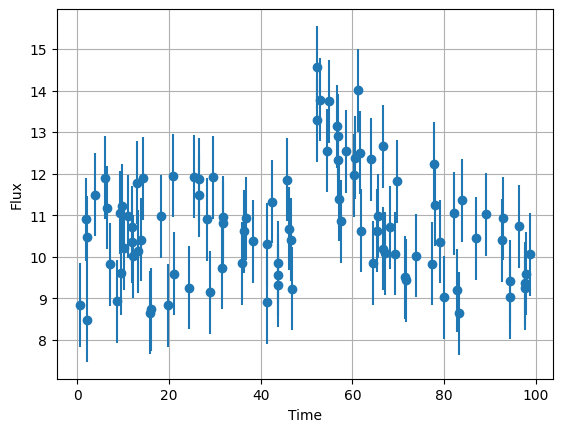

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")
print(data.shape)

time, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time, flux, yerr=err, fmt='o')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid()
plt.show()

## Bayesian fit of the data

To fit the data we have to compute the posterior distribution that is the product between the likelihood of the data and the prior distribution, our initial knowledge about the data. 

We can think to describe the data with a brust model like: 
$$
f(t) =
\begin{cases} 
b & \text{if } t < t_0 \\
b + A \cdot e^{-\alpha \cdot (t - t_0)} & \text{if } t \geq t_0
\end{cases}
$$

and we can think to use a prior distribution uniform in $b, A, t_0$ and linear in $\alpha$.
The logarithm of the prior is proportional to $\log(\alpha)$. 

On the other hand we can think to built a likelihood as a normal distribution between the data and the predicted data from the brust model. 
In this way the logarithm of the likelihood is simply the exponent of the gaussian: 
$$
-\frac{1}{2}\bigg(\frac{y-\hat{y}}{\sigma}\bigg)^2 = -\frac{1}{2}\chi^2
$$
where $\hat{y} = f(t)$.

## EMCEE library
To sample the posterior distribution we can use the `emcee` library that is a python implementation of the **affine invariant ensemble sampler** for Markov chain Monte Carlo (MCMC).

Remeber that an affine transformation is a linear transformation followed by a translation.
$$
y = Ax + b
$$
The affine invariant ensemble sampler is a MCMC method that is invariant under affine transformations of the parameter space. This means that the performance of the sampler does not depend on the scaling or rotation of the parameter space, making it more robust and efficient for sampling complex distributions.

In [2]:
def brust_model(t, theta):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))

b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)

def log_likelihood(theta, x, y, y_err, model=brust_model):
    y_fit = model(x, theta)
    chi2 = np.sum(((y - y_fit) / y_err) ** 2)
    return  -0.5 * chi2

def log_prior(theta):
    b, A, t0, alpha = theta
    if b_min < b < b_max and A_min < A < A_max and t0_min < t0 < t0_max and alpha_min < alpha < alpha_max:
        return -np.log(alpha) 
    return -np.inf # invalid region, if I am out of the true region , prob = 0 

def log_posterior(theta, x, y, y_err, model=brust_model):
    return log_likelihood(theta, x, y, y_err, model) + log_prior(theta)

In [3]:
b_0, A_0, t0_0, alpha_0 = np.median(flux[:50]), np.max(flux)-np.median(flux[:50]), time[np.argmax(flux)], 1
initial= np.array([b_0, A_0, t0_0, alpha_0])
print(initial)

ndim = len(initial)
nwalkers = 20 # the emcee algorithm requires multiple walkers instead of the Metropolis-Hastings single walker
# we use multiple walkers to explore the parameter space more efficiently
steps = 1e4 # number of steps for each walker

initial_guess = initial + 1e-1 * np.random.randn(nwalkers, ndim) # matrix for initial positions of the walkers
# each walker starts from a position close to the initial guess with some random noise
print(initial_guess)

[10.43656214  4.12137189 52.18483218  1.        ]
[[10.44935757  3.85694658 52.21542255  0.8946855 ]
 [10.28015955  4.23053082 52.18406729  0.95720288]
 [10.31226521  4.16221354 52.14930975  1.01750763]
 [10.45331699  4.27034565 52.24179353  0.94491426]
 [10.64212969  4.16599642 52.04435152  0.98790797]
 [10.37615527  4.11867733 52.31289555  0.90259915]
 [10.48803448  4.00723375 52.11160717  1.1982587 ]
 [10.48165021  4.21337337 52.22914539  0.95821815]
 [10.52209689  4.21482522 52.17016547  1.01675835]
 [10.2566418   4.23323456 52.17057204  0.90480313]
 [10.43894877  4.13312814 52.26631112  1.01157286]
 [10.4444412   3.96911707 52.1730408   0.76782557]
 [10.50366983  4.22101624 52.09709061  1.00170721]
 [10.44942197  4.18943425 52.04406918  1.19059004]
 [10.50501334  4.14401409 52.27974708  1.05364954]
 [10.42996152  4.22705208 52.35799061  1.12618887]
 [10.40434808  3.97727647 52.40217886  1.03940402]
 [10.43013672  4.21294255 52.18430843  1.03473338]
 [10.40376526  4.10014661 52.262

We use `emcee.EnsembleSampler` for generate lot of samples that after the first (burn in) points follow the posterior distribution. 
These samples are generated with multiple walker, and each of them has his own chain.
This is useful to explore the parameter space more efficiently.

100%|██████████| 10000/10000 [00:23<00:00, 425.62it/s]


(10000, 20, 4)


Text(0.5, 0, 'step number')

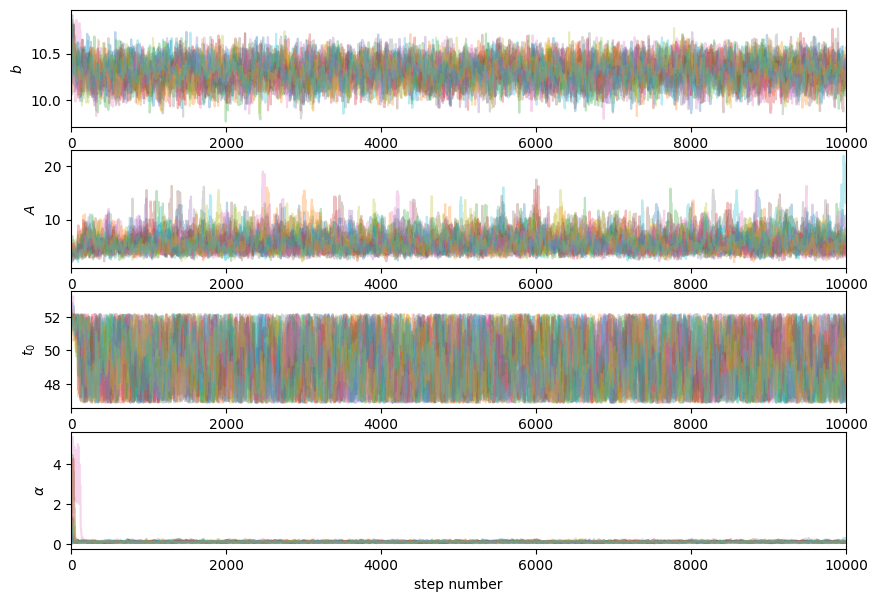

In [4]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[time, flux, err])
sampler.run_mcmc(initial_guess, int(steps), progress=True)

samples = sampler.get_chain()
print(samples.shape)
labels = [r'$b$', r'$A$', r'$t_0$', r'$\alpha$']

fig, axes = plt.subplots(4, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")

### Autocorrelation time

In general the samples generated with MCMC are not indipendent, because each sample is generated from the previous one. 
We can measure the number of steps necessary to generate indipendent samples, this is the **autocorrelation time**.

We can define the burn in as three times the maximum autocorrelation time value.

In [5]:
tau = sampler.get_autocorr_time()
print(tau)

burn_in = int(5 * np.max(tau))

[64.08433632 72.57143624 77.34322592 48.95599796]


In [6]:
flat_samples = sampler.get_chain(discard=burn_in, thin=int(max(tau)), flat=True)
# thin=int(max(tau)) -> This "thins" the chain by keeping only every max(tau)-th sample 
# Thinning ensures that the samples are approximately independent, reducing redundancy in the data.
print(flat_samples.shape)

(2480, 4)


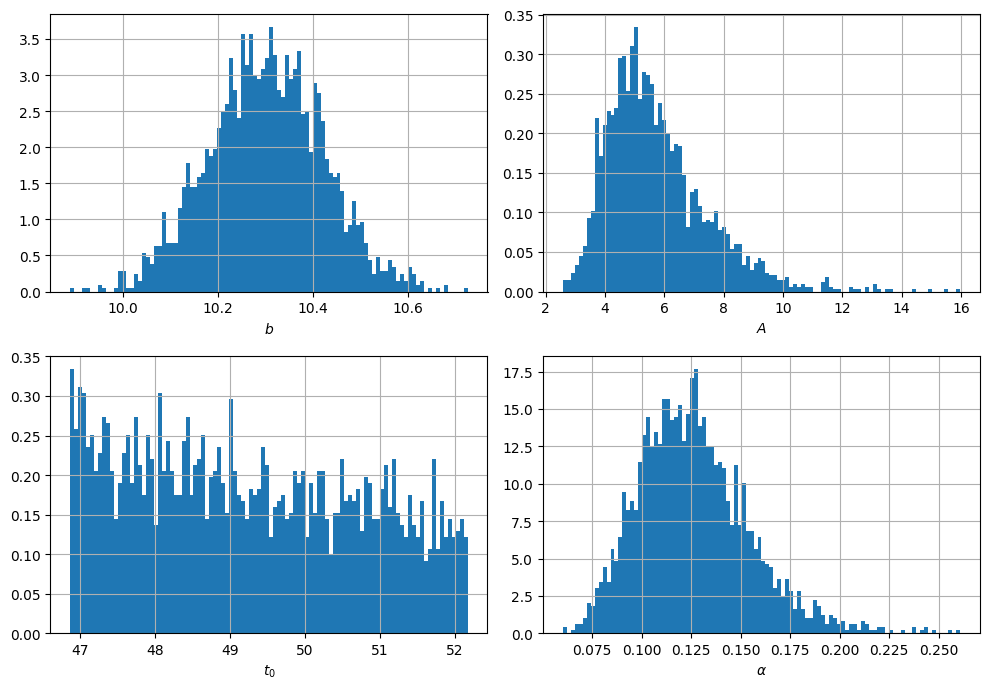

In [7]:
#plot the histograms of the parameters
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    ax.hist(flat_samples[:, i], bins=100, density=True)
    ax.set_xlabel(labels[i])
    ax.grid()
plt.tight_layout()
plt.show()

The distribution doesn't have simmetric shapes, so the best estimator we can use are the median with interquantile range.

Text(0.5, 0, 'step number')

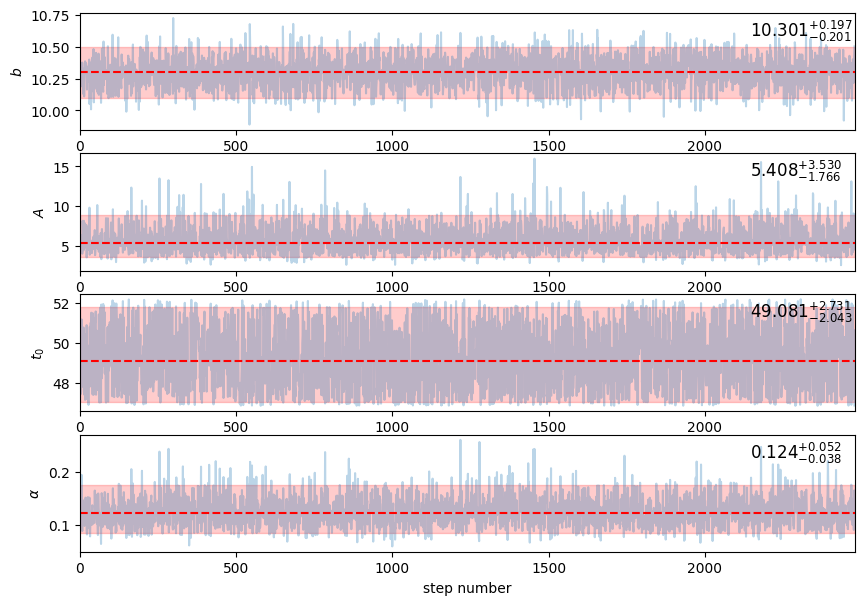

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], alpha=0.3)
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    
    lower, median, upper = np.percentile(flat_samples[:, i], [5, 50, 95])
    err_upper = upper - median
    err_lower = median - lower
    
    ax.axhline(median, linestyle="--", color='red')
    ax.fill_between(ax.get_xlim(), lower, upper, color='red', alpha=0.2) # 90% interquantile range
    
    ax.text(0.865, 0.8, rf"${median:.3f}^{{+{err_upper:.3f}}}_{{-{err_lower:.3f}}}$", transform=ax.transAxes, fontsize=12)

axes[-1].set_xlabel("step number")

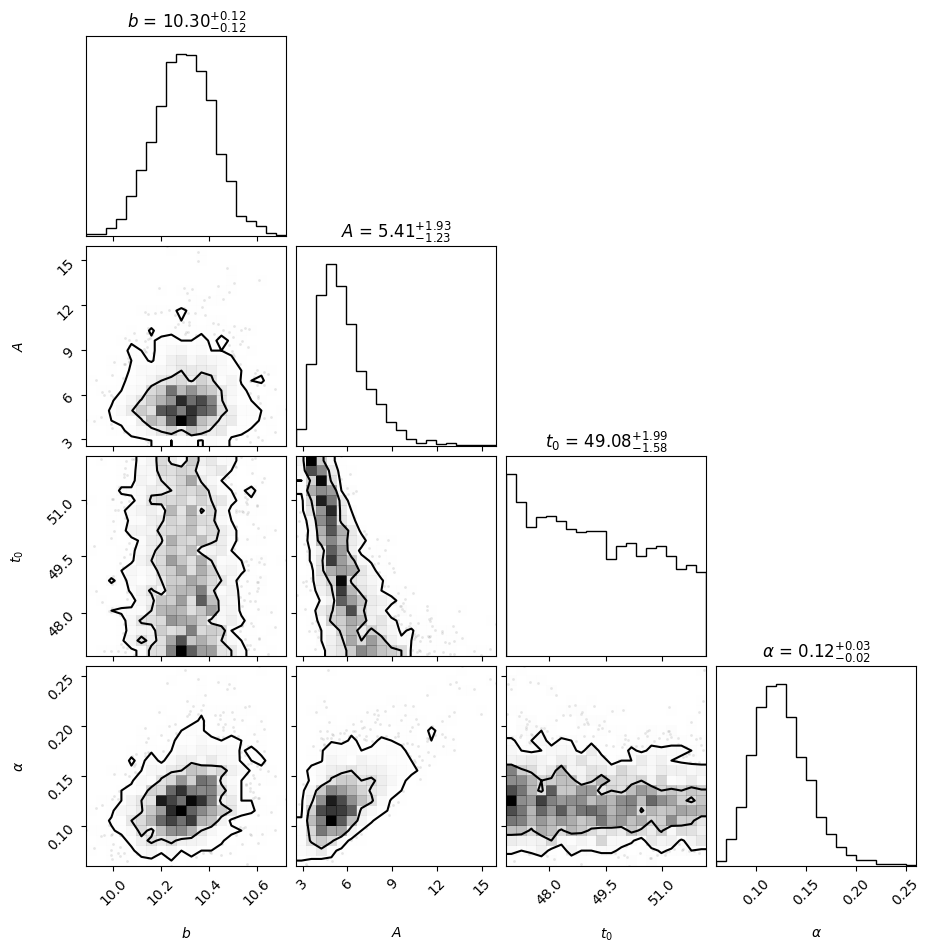

In [9]:
import corner

fig = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], show_titles=True)

We can now observe the result of the fit randomly sampling 100 different parameter sets

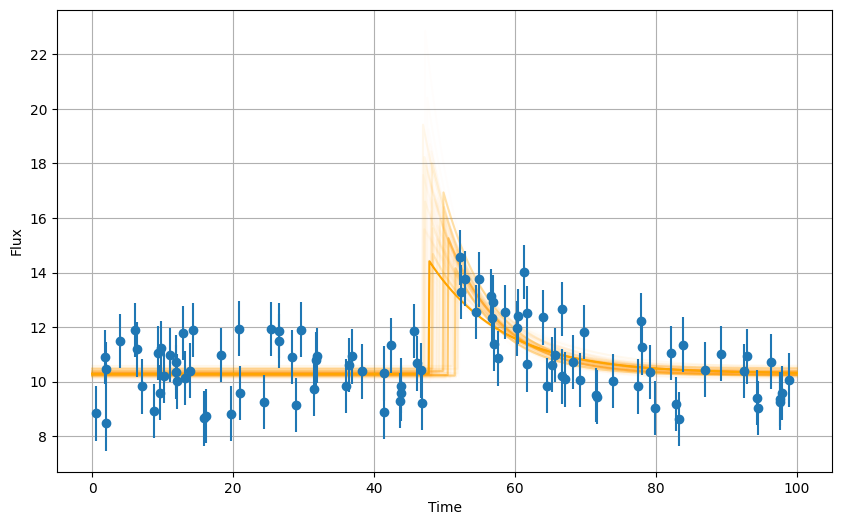

In [10]:
sample_choosen = flat_samples[np.random.choice(len(flat_samples), size=100)]
time_values = np.linspace(0, 100, 1000)

plt.figure(figsize=(10, 6))
for i, sample in enumerate(sample_choosen):
    plt.plot(time_values, brust_model(time_values, sample), color='orange', alpha=1/(i+1))
plt.errorbar(time, flux, yerr=err, fmt='o', label='data')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid()
plt.show()